In [113]:
import os.path as op
import sys
import os

import glob
import torch
import numpy as np
from PIL import Image
import yaml
import time

#pip install scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score

from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2

sys.path.append('..')


In [114]:
def freeze_layers(model, start: int, stop: int) -> None:
    """ Freezes the layers of a nn from start to stop indices

    Args:
        model: (torchvision.models)
            the model to use
        start: (int)
            the starting index
        stop: (int)
            the stopping index

    Returns:
        None
    """
    for name, child in model.named_children():
        if name == 'backbone':
            for i in range(start, stop):
                layer = child[str(i)].parameters()
                for parameter in layer:
                    parameter.requires_grad = False


def mean_iou(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """ Calculates the mean IoU (Jaccard index) between
        two tensors. Shape expected to be same.

    Args:
        outputs: (torch.Tensor)
            the output of a model
        labels: (torch.Tensor)
            the ground truth labels

    Returns:
        float
    """
    outputs = torch.from_numpy(outputs)
    labels = torch.from_numpy(labels)
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou_score = torch.sum(intersection) / torch.sum(union)
    return iou_score.mean()

def mean_iou(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """ Calculates the mean IoU (Jaccard index) between
        two tensors. Shape expected to be same.

    Args:
        outputs: (torch.Tensor)
            the output of a model
        labels: (torch.Tensor)
            the ground truth labels

    Returns:
        float
    """
    outputs = torch.from_numpy(outputs)
    labels = torch.from_numpy(labels)
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou_score = torch.sum(intersection) / torch.sum(union)
    return iou_score.mean()


def mean_accuracy(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    
    outputs = torch.from_numpy(outputs)
    labels = torch.from_numpy(labels)

    correct_pred = torch.logical_and(outputs, labels)

    accuracy_score = torch.sum(correct_pred).item() / torch.numel(labels)

    return accuracy_score


def imshow(image: Image) -> None:
    """ Displays an image

    Args:
        image: (Image) the input image to display

    Returns:
        None
    """
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))


def label_to_color_image(label: np.ndarray) -> np.ndarray:
    """ Adds color defined by the dataset colormap to the label.
        From https://github.com/tensorflow/models/tree/master/research/deeplab

    Args:
        label: (np.ndarray)
            A 2D array with integer type, storing the segmentation label.

    Returns:
        A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the CMU Yamaha dataset color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if len(label.shape) != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_cmu_yamaha_offroad_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def create_cmu_yamaha_offroad_label_colormap() -> np.ndarray:
    """ Creates a label colormap used in CMU Yamaha Offroad
        dataset segmentation dataset.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def relabel(mask: np.array):
    """Relabels mask to the right colors
    
    Args:
        mask: (np.ndarray)
        the mask to overlay

    Returns:
        realbeled image
    """
    color_map = {
    (0, 0, 0):(255, 255, 255),
    (128, 0, 0):(156, 76, 30),
    (0, 128, 0):(178, 176, 153),
    (128, 128, 0):(128, 255, 0),
    (0, 0, 128):(0, 160, 0),
    (128, 0, 128):(255, 0, 0),
    (0, 128, 128):(40, 80, 0),
    (128, 128, 128):(1, 88 ,255)
    }

    for original_col, new_col in color_map.items():
        
        new = np.all(mask == original_col, axis=-1)
    
        mask[new] = new_col

    return mask


def vis_segmentation(image: np.ndarray, mask: np.ndarray, seg_map: np.ndarray, name) -> None:
    """ Visualizes input image, segmentation map and overlay view
        From https://github.com/tensorflow/models/tree/master/research/deeplab

    Args:
        image: (np.ndarray)
            the rgb image
        seg_map: (np.ndarray)
            the mask to overlay

    Returns:
        None
    """
    label_names = np.asarray([
        'non-traversable', 'rough trail', 'smooth trail', 'traversable grass',
        'low vegetation', 'obstacle', 'high vegetation', 'sky'
    ])

    full_label_map = np.arange(len(label_names)).reshape(len(label_names), 1)
    full_color_map = label_to_color_image(full_label_map)

    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 3, width_ratios=[6, 6, 6])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(mask)
    plt.axis('off')
    plt.title('mask')

    seg_image_new = relabel(seg_image)

    plt.subplot(grid_spec[2])
    plt.imshow(seg_image_new)
    plt.axis('off')
    plt.title('segmentation overlay')

    plt.savefig(name, bbox_inches=0, transparent="True",
                 pad_inches=0)


def draw_segmentation(image: np.ndarray, seg_map: np.ndarray) -> np.ndarray:
    """ Visualizes input image overlayed with segmentation map

    Args:
        image: (np.ndarray)
            the rgb image
        seg_map: (np.ndarray)
            the mask to overlay

    Returns:
        overlay: (np.ndarray)
            input image overlayed with segmentation map
    """
    # label_names = np.asarray([
    #     'non-traversable', 'rough trail', 'smooth trail', 'traversable grass',
    #     'low vegetation', 'obstacle', 'high vegetation', 'sky'
    # ])

    # full_label_map = np.arange(len(label_names)).reshape(len(label_names), 1)
    # full_color_map = label_to_color_image(full_label_map)
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.5, seg_image, 0.5, 0)
    return overlay


def display_example_pair(image: np.ndarray, mask: np.ndarray) -> None:
    """ Visualizes input image and segmentation map. Used for visualizations.

    Args:
        image: (np.ndarray) the rgb image
        mask: (np.ndarray) the mask of the input image

    Returns:
        None
    """
    _, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask)
    ax[1].axis('off')
    ax[1].set_title('Mask')


def vis_grid_4x3(model, data_path: str) -> None:
    """ Visualizes a grid of original, mask, and predicted mask images.
        Used to visualize the results of multiple images after running
        inference.

    Args:
        model: (torchvision.models)
            the model to use to run inference

    Returns:
        None
    """
    images = []
    pair_directories = [op.join(data_path, 'train/iid000183'),
                        op.join(data_path, 'train/iid000657'),
                        op.join(data_path, 'train/iid000499'),
                        op.join(data_path, 'train/iid001092')]
    brown = [139, 69, 19]
    dark_green = [0, 100, 0]
    forest_green = [34, 139, 34]
    sky = [0, 0, 255]
    gray = [211, 211, 211]
    red = [255, 0, 0]
    green = [0, 255, 0]
    white = [255, 255, 255]
    colors = torch.as_tensor([white, green, brown, gray, forest_green, red,
                              dark_green, sky])
    colors = (colors).numpy().astype("uint8")
    for i in range(4):
        image_mask_pair = glob.glob(pair_directories[i] + '/*')
        path1, path2 = image_mask_pair
        mask = Image.open(path1)
        mask = np.array(mask.convert('RGB'))
        image = Image.open(path2)
        seg_map = run_inference(model, image)
        seg_map.putpalette(colors)
        seg_map = seg_map.convert('RGB')
        seg_map = np.array(seg_map)
        images = images + [image, mask, seg_map]
    plt.figure(figsize=(10, 10))
    col = ['Original', 'Mask', 'Ours']
    for i in range(len(images)):
        ax = plt.subplot(4, 3, i+1)
        if i < 3:
            ax.set_title(col[i])
        plt.imshow(images[i])
        plt.axis("off")
    plt.subplots_adjust(wspace=.01, hspace=-0.6)
    # plt.savefig('sample.png', bbox_inches=0, transparent="True",
    #             pad_inches=0)


def run_inference(model, image):
    """ Runs inference on a single image with the given model

    Args:
        model: (torchvision.models)
            the model to use
        image: (np.ndarray)
            the image to use

    Returns:
        (Image) the segmentation map predicted by the model
    """
    # apply the same transforms that were applied to input images when training the model
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    # put the image in a batch (as expected by the model)
    input_batch = input_tensor.unsqueeze(0)
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    if isinstance(image, np.ndarray):
        return Image.fromarray(output_predictions.byte().cpu().numpy()).resize((image.shape[1], image.shape[0]))
    return Image.fromarray(output_predictions.byte().cpu().numpy()).resize(image.size)


def save_video(frames: list, outfile_path: str) -> None:
    """ Saves a list of frames to a video file.

    Args:
        frames: list
            List of frames to process into a video
        outfile_path: str
            Path to write the video to
    """
    h, w, *_ = frames[0].shape
    outfile = cv2.VideoWriter(outfile_path, -1, 30, (w, h))
    for frame in frames:
        outfile.write(frame)
    outfile.release()

In [115]:
torch.cuda.is_available()

True

In [116]:
np.random.seed(42)

change the path to config file

In [117]:
with open('/home/nb1/spilkova/data/semantic-segmentation/config/training_configs/conf_mnv3_yamaha.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [118]:
data_path = config['DATA_PATH']

Load a previously trained model and run the image through it

In [119]:
model = torch.load(op.join('/home/nb1/spilkova/data/semantic-segmentation/', config['LOAD_MODEL_PATH']))
model.eval();

mean time is: 0.03401821562802984
accuracy: 0.5739334564334115
mIoU: 0.5756896936130124


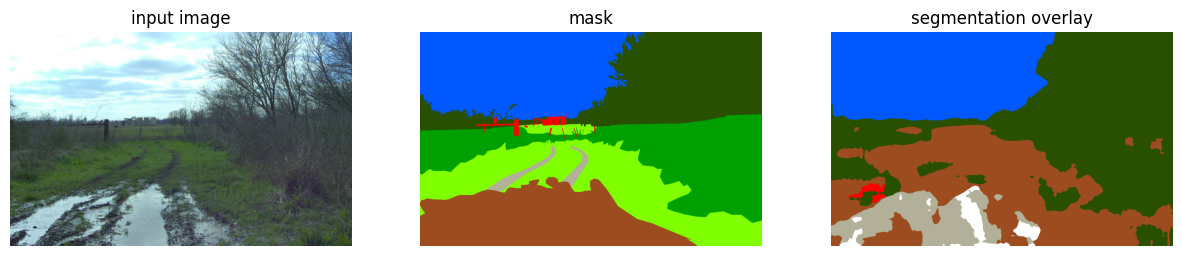

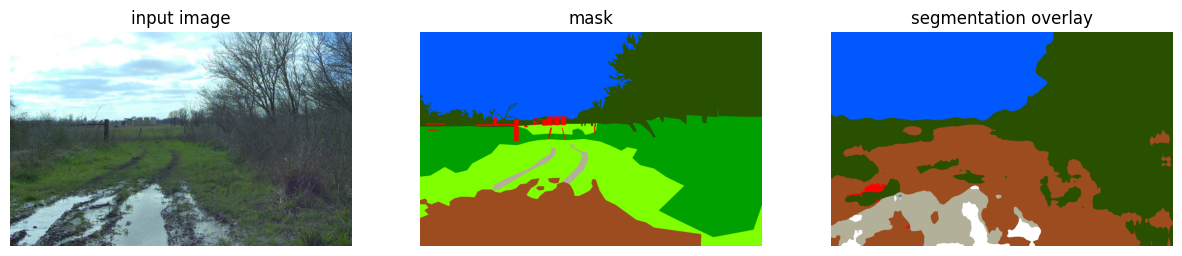

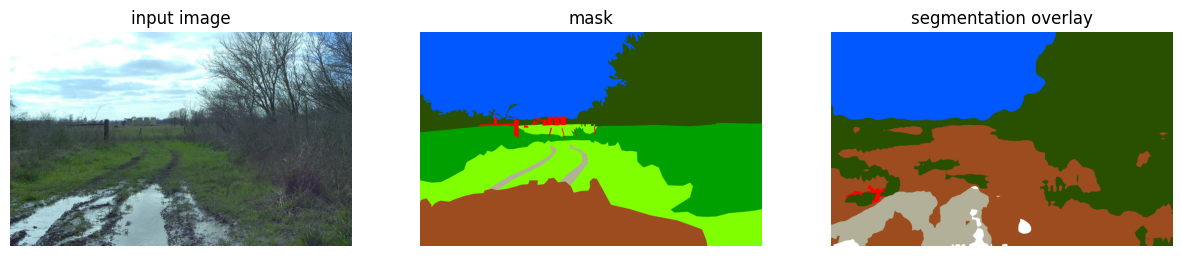

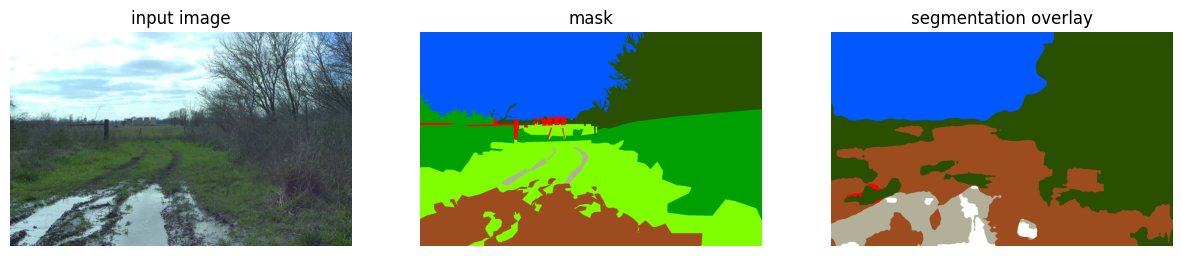

In [120]:
small_mean = 0
small_accuracy = 0
count = 0
timer = 0

mask_folder = "/home/nb1/spilkova/data/Rellis-3D/"
image_folder = "/home/nb1/spilkova/data/Rellis-3D/"
lst_file_path = "/home/nb1/spilkova/data/Rellis-3D/test.lst"

with open(lst_file_path, 'r') as lst_file:
    for line in lst_file:
        image_file, mask_file = line.strip().split()

        test_image = Image.open(op.join(image_folder, image_file))
        test_mask = Image.open(op.join(mask_folder, mask_file))
        image_display = np.array(test_image)
        mask_display = np.array(test_mask.convert('RGB'))

        t = time.time()
        predicted_masks = run_inference(model, test_image)
        t1 = time.time() - t
        timer += t1
        
        predicted_display = np.array(predicted_masks.convert('RGB'))

        small_mean += mean_iou(predicted_display, mask_display)
        small_accuracy += mean_accuracy(predicted_display, mask_display)

        if image_file.startswith("00000/pylon_camera_node/frame00000"):
            name = config['BACKBONE'] + str(config['NUM_EPOCHS']) + "_rellis_" + str(count)
            path = "/home/nb1/spilkova/data/outs"
            vis_segmentation(test_image, np.array(test_mask.convert('RGB')), np.array(predicted_masks), op.join(path, name))

        count += 1

ttt = timer/count
total_mean = small_mean.item()/count
total_accuracy = small_accuracy/count

print("mean time is: %s" % ttt)
print("accuracy:", total_accuracy)
print("mIoU:", total_mean)

Finally, we take the orginal example image, and using the segmentation map, a custom color map for our labels, and the label names, overlay the segmentation map and create a key for each of the classes

In [121]:
#display_example_pair(np.array(test_image), np.array(test_mask.convert('RGB')))
# vis_segmentation(test_image, np.array(test_mask.convert('RGB')), np.array(predicted_masks))